<a href="https://colab.research.google.com/github/Marrie05/RhombixTechnologies_Tasks/blob/main/STOCK_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Import Libraries:

You'll use Python libraries like:

In [1]:
# 1) Install requirements (run once)
# !pip install yfinance numpy pandas scikit-learn matplotlib tensorflow
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2. Load Stock Price Data:

You can use Yahoo Finance data of any company, like Apple (AAPL):

In [2]:
# 2) Parameters
TICKER = "AAPL"
START_DATE = "2015-01-01"   # change as needed
END_DATE = "2024-12-31"     # None => up to today
SEQ_LEN = 60                # number of past days used to predict next day
TEST_SIZE = 0.2             # fraction for test set
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001

In [3]:
import yfinance as yf
# 3) Download historical data
df = yf.download(TICKER, start=START_DATE, end=END_DATE)  # uses Yahoo Finance
# Keep only 'Close' price (you can expand to OHLCV or technical features)
data = df[['Close']].dropna()

/tmp/ipython-input-246754534.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE)  # uses Yahoo Finance
[*********************100%***********************]  1 of 1 completed


3. Preprocess the Data:

Use only the "Close" prices.
Scale the values between 0 and 1 using MinMaxScaler.
Create sequences (X) and targets (y) for the LSTM model.

In [4]:
# 4) Scale data to [0,1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data.values)

# 5) Create sequences: X = last SEQ_LEN closes, y = next close
def create_sequences(arr, seq_len):
    xs = []
    ys = []
    for i in range(len(arr) - seq_len):
        xs.append(arr[i:i+seq_len])
        ys.append(arr[i+seq_len])
    return np.array(xs), np.array(ys)

X, y = create_sequences(scaled, SEQ_LEN)

# 6) Train/test split (time series split — do not shuffle)
split_idx = int(len(X) * (1 - TEST_SIZE))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

4. Build the LSTM Model:

Create a Sequential model with LSTM layers and Dense output.

In [5]:
# 7) Build LSTM model
tf.keras.backend.clear_session()
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5. Train the Model:

Train it on historical data to learn patterns.

In [6]:
# 8) Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Epoch 1/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 7.9165e-04 - val_loss: 0.0442
Epoch 2/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0093 - val_loss: 0.0707
Epoch 3/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0158 - val_loss: 0.0199
Epoch 4/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0244 - val_loss: 0.0164
Epoch 5/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0330 - val_loss: 0.0033
Epoch 6/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0180 - val_loss: 0.0114
Epoch 7/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0299 - val_loss: 0.0061
Epoch 8/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 9/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0043 - val_loss: 0.0050
Epoch 10/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 9.9983e-04 - val_loss: 0.0057
Epoch 11/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 6.0023e-04 - val_loss: 0.0058
Epoch 12/30
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step

6. Predict Future Prices:

Use test data to predict and compare with real values.

In [7]:
# 9) Predictions (and inverse-scaling)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Inverse scale
pred_train_inv = scaler.inverse_transform(pred_train)
y_train_inv = scaler.inverse_transform(y_train)
pred_test_inv = scaler.inverse_transform(pred_test)
y_test_inv = scaler.inverse_transform(y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [8]:
# 10) Evaluate with RMSE
rmse_train = math.sqrt(mean_squared_error(y_train_inv, pred_train_inv))
rmse_test = math.sqrt(mean_squared_error(y_test_inv, pred_test_inv))
print(f"RMSE (train): {rmse_train:.4f}")
print(f"RMSE (test) : {rmse_test:.4f}")

RMSE (train): 12.6114
RMSE (test) : 21.4988


7. Visualize the Result:

Plot actual vs predicted prices using matplotlib.

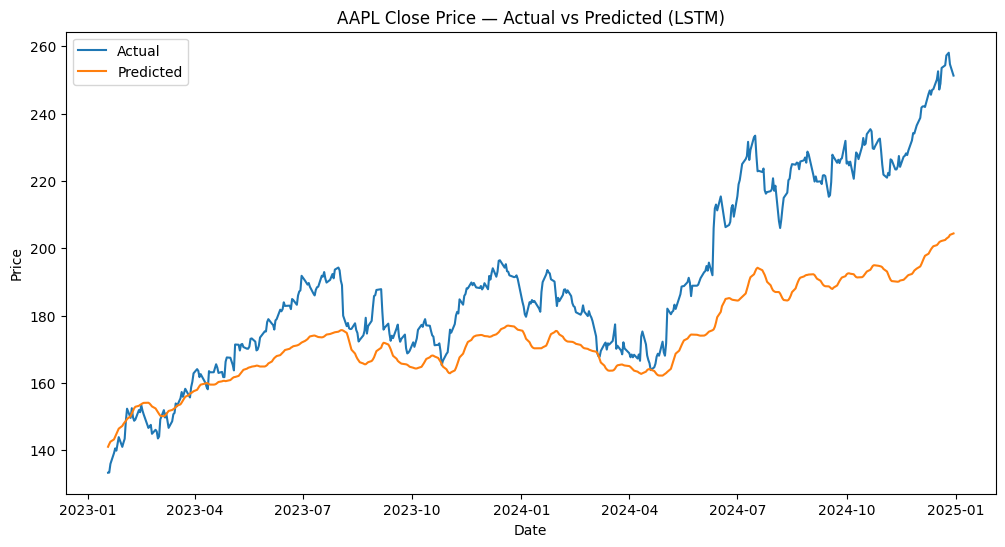

In [9]:
# 11) Plot actual vs predicted (test)
plt.figure(figsize=(12,6))
plt.plot(data.index[-len(y_test_inv):], y_test_inv, label="Actual")
plt.plot(data.index[-len(pred_test_inv):], pred_test_inv, label="Predicted")
plt.title(f"{TICKER} Close Price — Actual vs Predicted (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [10]:
# 12) Predict next day price (one-step ahead)
# Take last SEQ_LEN days from the scaled array:
last_seq = scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, 1)
next_pred_scaled = model.predict(last_seq)
next_pred = scaler.inverse_transform(next_pred_scaled)
print(f"Next day predicted Close price for {TICKER}: {next_pred[0,0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Next day predicted Close price for AAPL: 204.5349
